In [ ]:
# This notebook will leverage nursing data from CMS to draw on several insights

# Data Methodology
# https://data.cms.gov/resources/payroll-based-journal-methodology-0

# Data Dictionaries / Glossaries / indexes
# https://data.cms.gov/resources/payroll-based-journal-daily-non-nurse-staffing-data-dictionary
# https://data.cms.gov/resources/payroll-based-journal-daily-nurse-staffing-data-dictionary
# https://www.kaggle.com/datasets/miadul/overstimulation-behavior-and-lifestyle-dataset
# https://www.kaggle.com/datasets/manuelcamachor/level-of-anxiety-in-nursing-during-covid-pandemic

# Datasets
# https://data.cms.gov/quality-of-care/payroll-based-journal-daily-non-nurse-staffing/data
# https://data.cms.gov/quality-of-care/payroll-based-journal-daily-nurse-staffing/data
# https://www.kaggle.com/datasets/miadul/overstimulation-behavior-and-lifestyle-dataset
# https://www.kaggle.com/datasets/manuelcamachor/level-of-anxiety-in-nursing-during-covid-pandemic

In [ ]:
from pandas.conftest import compression
# Setup
!pip install polars

## Download Data - (You will not need to run this)


In [349]:
################################################## Inspect/Prepare Data ##################################################
# 1. download files from api
# 2. adjust table layouts
# 3. write csv files to parquet (smaller)
################################################## Inspect/Prepare Data ##################################################
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import polars as pl
import requests
import os
import time
import requests
import polars as pl
import os

api_download=False
change_layout=False
build_parquet=False

if api_download:
    # define datasets for api acquisition
    non_nursing_data = [
        {
            "type": "Non-Nursing Staffing",
            "quarter": "Q3",
            "year": "2024",
            "id": "293788f3-20a9-4ebd-ab4a-9989325ce3e7"
        },
        {
            "type": "Non-Nursing Staffing",
            "quarter": "Q2",
            "year": "2024",
            "id": "c06ad548-5cb2-4f29-8075-66efc2d195b6"
        },
        {
            "type": "Non-Nursing Staffing",
            "quarter": "Q1",
            "year": "2024",
            "id": "86603f7e-6ed8-4005-a5d3-b13d2ebcf3d4"
        }
    ]
    non_nursing_data = [non_nursing_data[2]]
    nursing_data = [
        {
            "type": "Nursing Staffing",
            "quarter": "Q3",
            "year": "2024",
            "id": "989fbc78-1655-487d-9f24-d68e9a0ab3af"
        },
        {
            "type": "Nursing Staffing",
            "quarter": "Q2",
            "year": "2024",
            "id": "dcc467d8-5792-4e5d-95be-04bf9fc930a1"
        },
        {
            "type": "Nursing Staffing",
            "quarter": "Q1",
            "year": "2024",
            "id": "5b84bdf2-b246-4b3c-be1b-cf7c2bcb3391"
        }
    ]
    nursing_data = [nursing_data[2]]
    
    data_sets = nursing_data #+ non_nursing_data
    
    # optional
    data_frames = []
    
    # directory of where this notebook will be run
    base_dir = os.getcwd()+"\\data\\"
    
    # avoid extra api calls
    for item in data_sets:
        file = [str(val) for val in item.values()]
        file = "-".join(file)+".tsv"
        this_file = base_dir+file
        
        if os.path.exists(this_file):
            pass # df = pl.read_csv(this_file, separator='\t')
            # data_frames.append(df)
        else:
            _id = item['id']
            
            # get the base url
            api_url = "https://data.cms.gov/data-api/v1/dataset/"+_id+"/data"
            
            # places to store data
            _data = []
            
            # get number of rows
            response = requests.get(api_url+"/stats")
            rows = response.json()
            total_rows = rows.get("total_rows")
            i = 0 
            
            # api docs stated they can provide 5k per call but only 1k is in the response
            print(f"obtaining {total_rows} rows 1000 at a time")
            while i < total_rows: 
                size = 1000
                offset_url = f"{api_url}?/size={size}&offset={i}"
                offset = i
                offset_response = requests.get(offset_url)
                print(f"Made request for {size} results at offset {i}")
                items = offset_response.json()
                for item in items:
                    _data.append(item)
                i = i+size
                print(["Size is now:",len(_data)])
                time.sleep(0.5)     
                
            df = pl.DataFrame(_data)
            df.write_csv(this_file,include_header=True,separator="\t",line_terminator="\n",quote_char='"',null_value="NA")
            time.sleep(120)

if change_layout:
    pl.Config.set_tbl_width_chars(100)
    pl.Config.set_fmt_str_lengths(100)
    
if build_parquet:
    
    base_dir = os.getcwd()+"\\data\\"

    nurses = pl.read_csv(base_dir+"Nursing Staffing-Q1-2024-5b84bdf2-b246-4b3c-be1b-cf7c2bcb3391.tsv", separator="\t", infer_schema_length=10000,ignore_errors=True)
    
    non_nurses = pl.read_csv(base_dir+"Non-Nursing Staffing-Q2-2024-86603f7e-6ed8-4005-a5d3-b13d2ebcf3d4.tsv", separator="\t", infer_schema_length=10000,ignore_errors=True)
    
    provider_infoJan = pl.read_csv(base_dir+"NH_ProviderInfo_Feb2024.csv", infer_schema_length=10000,ignore_errors=True)
    provider_infoFeb = pl.read_csv(base_dir+"NH_ProviderInfo_Mar2024.csv", infer_schema_length=10000,ignore_errors=True)
    provider_infoMar = pl.read_csv(base_dir+"NH_ProviderInfo_Apr2024.csv", infer_schema_length=10000,ignore_errors=True)

    provider_info = provider_infoJan.vstack(provider_infoFeb)
    provider_info = provider_info.vstack(provider_infoMar)

    print("Saving Parquet")
    # the data is prepared on the first of the month, for the month, so jan file is dec data of prev yr
    # i havent validated but i have both set of options
    provider_info.write_csv("data/Provider_Info_Jan_Feb_Mar.tsv", separator='\t')
    
    # Save the DataFrame to a Parquet file with compression
    provider_info.write_parquet("parquet/Providers.parquet", compression="zstd")
    nurses.write_parquet("parquet/Nurses.parquet", compression="zstd")
    non_nurses.write_parquet("parquet/Non-Nurses.parquet", compression="zstd")
    
    print("Saved Parquet")


Total Hours: 45625.189999999995
Employee Hours: 35137.75000000001
Contract Hours: 10487.44
Employee and contract hours equal total hours
the % of mistakes in the Admin field is: 0.6361856823266219
Hrs_RNDON_emp is in nurses


# Read data, cleanse it, explore it, verify fields etc

In [ ]:
################################################## Inspect/Prepare Data ##################################################
## Task:
#1. Data Familiarity & Exploration  
# • Load and explore the dataset (can be any public dataset or one provided by you – e.g., UCI, Kaggle). 

# 1. Load data from parquet files
# 2. cleanse data 
#    • remove null keys
#    • format date fields
#    • verify employee hours + contract hours == total hours 
#    • inspect footnote and impact on data
# 3. verify data dictionary integrity
################################################## Inspect/Prepare Data ##################################################
################################################################################################################### 1
# load data
nurses = pl.read_parquet("parquet/Nurses.parquet")
non_nurses = pl.read_parquet("parquet/Non-Nurses.parquet")
provider_info = pl.read_parquet("parquet/Providers.parquet")

################################################################################################################### 2
# let's work with identifiable facilities
nurses = nurses.filter(pl.col("PROVNUM").is_not_null())
non_nurses = non_nurses.filter(pl.col("PROVNUM").is_not_null())

# I noticed the WorkDate and date processed col is not a date, string with date
nurses = nurses.with_columns(pl.col("WorkDate").cast(pl.Utf8).alias("WorkDate"))
non_nurses = non_nurses.with_columns(pl.col("WorkDate").cast(pl.Utf8).alias("WorkDate"))
# date
nurses = nurses.with_columns(pl.col("WorkDate").str.strptime(pl.Date, "%Y%m%d").alias("WorkDate"))
non_nurses = non_nurses.with_columns(pl.col("WorkDate").str.strptime(pl.Date, "%Y%m%d").alias("WorkDate"))
provider_info = provider_info.with_columns(pl.col("Processing Date").str.strptime(pl.Date, "%Y-%m-%d").alias("Processing Date"))

# the max provnum is for prov 335232, the data dict does not explicitly state the emp and ctr fields add to total
# this could be assumed but, check first to ensure understanding is clear. these three expression yield this is true
# and our thinking was correct. Every role in the data follows this format so that clears up basically all the fields
# I used the max, for not particular reason other than I was curious about it, and it was a key i had handy
_nurses = nurses.group_by("PROVNUM").agg(pl.sum('Hrs_RN').alias('Registered Nurses')).sort('Registered Nurses', descending=True)
print("Total Hours:",_nurses[0]["Registered Nurses"][0])

__nurses = nurses.group_by("PROVNUM").agg(pl.sum('Hrs_RN_emp').alias('Registered Nurses emp')).filter(pl.col('PROVNUM') == 335232)
print("Employee Hours:",__nurses[0]["Registered Nurses emp"][0])

___nurses = nurses.group_by("PROVNUM").agg(pl.sum('Hrs_RN_ctr').alias('Registered Nurses ctr')).filter(pl.col('PROVNUM') == 335232)
print("Contract Hours:",___nurses[0]["Registered Nurses ctr"][0])

# is the difference small because of rounding only
if _nurses[0]["Registered Nurses"][0] - __nurses[0]["Registered Nurses emp"][0] - ___nurses[0]["Registered Nurses ctr"][0] < 1:
    print("Employee and contract hours equal total hours")
else:
    print(False)

# this field from non nurses is different   
#    "Hrs_Admin fn": "Footnote for Administrator Hours worked: 1 = Provider submitted invalid administrator hours",
# what do they mean by this, how often are there mistakse, inspect 
_non_nurses = non_nurses.filter(pl.col("Hrs_Admin_fn") != "1")['Hrs_Admin_fn']
no_mistake = len(_non_nurses)
_non_nurses = non_nurses.filter(pl.col("Hrs_Admin_fn") == "1")['Hrs_Admin_fn']
mistake = len(_non_nurses)

print("the % of mistakes in the Admin field is:", mistake/no_mistake*100) # <1% is basically irrelevant, but could have been

################################################################################################################### 3
# I don't see a "Hrs_RNDON_emp" in my data dictionary above - lets check if I missed copying it or if it is not there
if "Hrs_RNDON_emp" in nurses.columns:
    print("Hrs_RNDON_emp is in nurses")
# it is in the columns, I made a copy/paste error in making my data dict - I will add it back and note it

# Explore data for insights about nurses, and visualize the results
I also use this pattern to setup data for the ML model - numbers 4 through 6 below
Yes, I probably could have done these calculations straight away without repeating the code, but I had something that worked in milliseconds, and it is fine for my needs at this time.. 


shape: (5, 5)
┌─────────────────────────────────┬────────────┬────────────┬─────────────┬─────────────┐
│ PROVNAME                        ┆ Hrs_RN     ┆ Hrs_LPN    ┆ Hrs_CNA     ┆ total_work  │
│ ---                             ┆ ---        ┆ ---        ┆ ---         ┆ ---         │
│ str                             ┆ f64        ┆ f64        ┆ f64         ┆ f64         │
╞═════════════════════════════════╪════════════╪════════════╪═════════════╪═════════════╡
│ ISABELLA GERIATRIC CENTER INC   ┆ 355.871758 ┆ 305.090549 ┆ 1508.942527 ┆ 2169.904835 │
│ KINGS HARBOR MULTICARE CENTER   ┆ 259.547582 ┆ 435.883407 ┆ 1424.949231 ┆ 2120.38022  │
│ COLER REHABILITATION AND NURSI… ┆ 488.407802 ┆ 242.79011  ┆ 1338.508681 ┆ 2069.706593 │
│ THE PLAZA REHAB AND NURSING CE… ┆ 343.085824 ┆ 325.310549 ┆ 1274.604725 ┆ 1943.001099 │
│ COLD SPRING HILLS CENTER FOR N… ┆ 253.788791 ┆ 320.260989 ┆ 1352.201758 ┆ 1926.251538 │
└─────────────────────────────────┴────────────┴────────────┴─────────────┴───────────

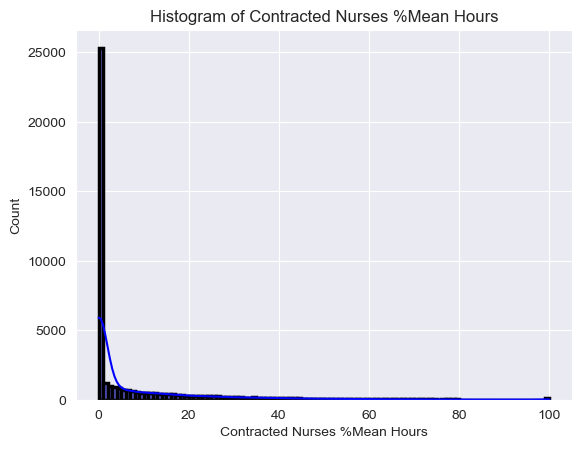

Contracted Nurses work Smaller Percentages of all Hours


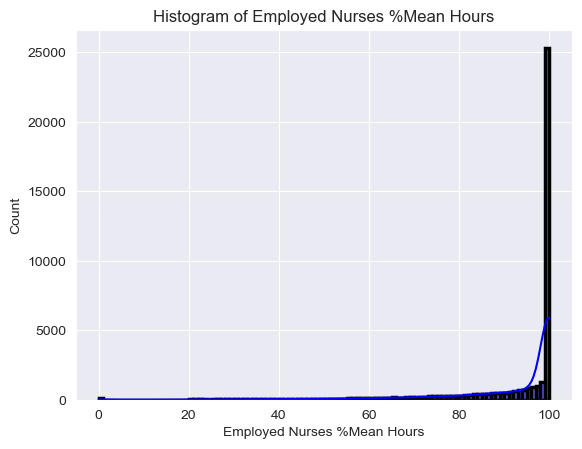

Employed Nurses work Most Hours


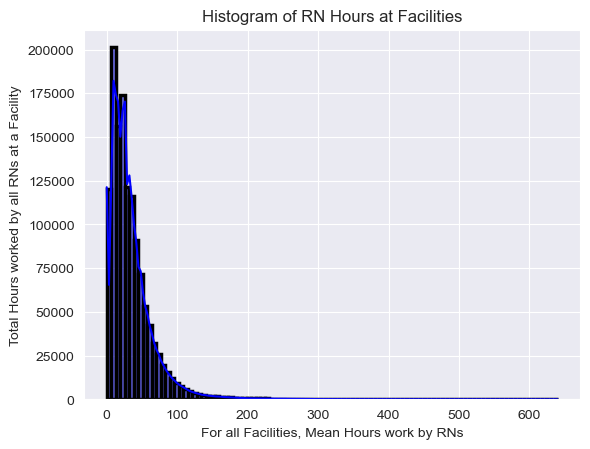

Most facilities have a smaller number of Registered Nnurses, and therefore less total worked hours


Most Nurses will work 8 hrs, so on average all nursing homes have about 5 RNs, given the ~40hrs worked a day


Pharmacists work very little hours compared to nurses


Physician Assistants work more than Pharmacists but less than nurses


Registered Nurses in not leadership roles work the most total hours


Nursing Assistants work the most hours, followed by Licences Professional Nurses and Registered Nurses


All other roles work an order of magnitude less than Nurses
Learning how much Nurses work compared to everyone else at nursing homes, I am curious what % of them are employed or work on contract


In [391]:
################################################## Data Insights ##################################################
## Task:
#1. Data Familiarity & Exploration  
# • Identify key trends and what the data might say about the user. 

# 1. dynamically load keys to perform operations with
# 2. perform an exploration and become familiar with the data
# 3. perform several visualizations to become familiar with the different types of nurses and the hours they work
## Show Visualizations
show=True
# 4. I noticed 3 nurses do most of the work, so for the three month period, I am using computing if most work came
#    from contracts or employees and labeling the data in this manner for the ML aspect of the assignment 
# 5. nurses data is 3 months in one file, break into 3 separate sets of data for Jan Feb March
# 6. store output data as one parquet file
################################################## Data Insights ##################################################
################################################################################################################### 1
from datetime import datetime

# this exists for validation as much as a way to label things and for validation. It is useful.
data_definitions = {
    "PROVNUM": "Medicare provider number",
    "PROVNAME": "Provider name",
    "CITY": "Provider City",
    "STATE": "Postal abbreviation for State",
    "COUNTY_NAME": "Name of Provider County, unique within state",
    "COUNTY_FIPS": "FIPS Code for Provider County, unique within state",
    "CY_Qtr": "Calendar Quarter (yyyyQq, e.g. 2018Q4)",
    "WorkDate": "Day for Reported Hours (yyyymmdd)",
    "MDScensus": "Resident Census from MDS",
    "Hrs_RNDON": "Total Hours for RN Director of Nursing", # no EMP?
    "Hrs_RNDON_emp": "Employee Hours for RN Director of Nursing", # this was missing and confirmed below
    "Hrs_RNDON_ctr": "Contract Hours for RN Director of Nursing",
    "Hrs_RNadmin": "Hours for RN with administrative duties",
    "Hrs_RNadmin_emp": "Employee Hours for RN with administrative duties",
    "Hrs_RNadmin_ctr": "Contract Hours for RN with administrative duties",
    "Hrs_RN": "Total Hours for RN",
    "Hrs_RN_emp": "Employee Hours for RN",
    "Hrs_RN_ctr": "Contract Hours for RN",
    "Hrs_LPNadmin": "Total Hours for LPN w/ admin duties",
    "Hrs_LPNadmin_emp": "Employee Hours for LPN w/ admin duties",
    "Hrs_LPNadmin_ctr": "Contract Hours for LPN w/ admin duties",
    "Hrs_LPN": "Total Hours for LPN",
    "Hrs_LPN_emp": "Employee Hours for LPN",
    "Hrs_LPN_ctr": "Contract Hours for LPN",
    "Hrs_CNA": "Total Hours for CNA",
    "Hrs_CNA_emp": "Employee Hours for CNA",
    "Hrs_CNA_ctr": "Contract Hours for CNA",
    "Hrs_NAtrn": "Total Hours for Nurse aide in training",
    "Hrs_NAtrn_emp": "Employee Hours for Nurse aide in training",
    "Hrs_NAtrn_ctr": "Contract Hours for Nurse aide in training",
    "Hrs_MedAide": "Total Hours for Med Aide/Technician",
    "Hrs_MedAide_emp": "Employee Hours for Med Aide/Technician",
    "Hrs_MedAide_ctr": "Contract Hours for Med Aide/Technician",
    #
    "Hrs_Admin": "Total Hours for Administrator",
    "Hrs_Admin_emp": "Employee Hours for Administrator",
    "Hrs_Admin_ctr": "Contract Hours for Administrator",
    "Hrs_Admin fn": "Footnote for Administrator Hours worked: 1 = Provider submitted invalid administrator hours",
    "Hrs_MedDir": "Total Hours for Medical Director",
    "Hrs_MedDir_emp": "Employee Hours for Medical Director",
    "Hrs_MedDir_ctr": "Contract Hours for Medical Director",
    "Hrs_OthMD": "Total Hours for Other Physician",
    "Hrs_OthMD_emp": "Employee Hours for Other Physician",
    "Hrs_OthMD_ctr": "Contract Hours for Other Physician",
    "Hrs_PA": "Total Hours for Physician Assistant",
    "Hrs_PA_emp": "Employee Hours for Physician Assistant",
    "Hrs_PA_ctr": "Contract Hours for Physician Assistant",
    "Hrs_NP": "Total Hours for Nurse Practitioner",
    "Hrs_NP_emp": "Employee Hours for Nurse Practitioner",
    "Hrs_NP_ctr": "Contract Hours for Nurse Practitioner",
    "Hrs_ClinNrsSpec": "Total Hours for Clinical Nurse Specialist",
    "Hrs_ClinNrsSpec_emp": "Employee Hours for Clinical Nurse Specialist",
    "Hrs_ClinNrsSpec_ctr": "Contract Hours for Clinical Nurse Specialist",
    "Hrs_Pharmacist": "Total Hours for Pharmacist",
    "Hrs_Pharmacist_emp": "Employee Hours for Pharmacist",
    "Hrs_Pharmacist_ctr": "Contract Hours for Pharmacist",
    "Hrs_Dietician": "Total Hours for Dietician",
    "Hrs_Dietician_emp": "Employee Hours for Dietician",
    "Hrs_Dietician_ctr": "Contract Hours for Dietician",
    "Hrs_FeedAsst": "Total Hours for Feeding Assistant",
    "Hrs_FeedAsst_emp": "Employee Hours for Feeding Assistant",
    "Hrs_FeedAsst_ctr": "Contract Hours for Feeding Assistant",
    "Hrs_OT": "Total Hours for Occupational Therapist",
    "Hrs_OT_emp": "Employee Hours for Occupational Therapist",
    "Hrs_OT_ctr": "Contract Hours for Occupational Therapist",
    "Hrs_OTasst": "Total Hours for Occupational Therapy Assistant",
    "Hrs_OTasst_emp": "Employee Hours for Occupational Therapy Assistant",
    "Hrs_OTasst_ctr": "Contract Hours for Occupational Therapy Assistant",
    "Hrs_OTaide": "Total Hours for Occupational Therapy Aide",
    "Hrs_OTaide_emp": "Employee Hours for Occupational Therapy Aide",
    "Hrs_OTaide_ctr": "Contract Hours for Occupational Therapy Aide",
    "Hrs_PT": "Total Hours for Physical Therapist",
    "Hrs_PT_emp": "Employee Hours for Physical Therapist",
    "Hrs_PT_ctr": "Contract Hours for Physical Therapist",
    "Hrs_PTasst": "Total Hours for Physical Therapy Assistant",
    "Hrs_PTasst_emp": "Employee Hours for Physical Therapy Assistant",
    "Hrs_PTasst_ctr": "Contract Hours for Physical Therapy Assistant",
    "Hrs_PTaide": "Total Hours for Physical Therapy Aide",
    "Hrs_PTaide_emp": "Employee Hours for Physical Therapy Aide",
    "Hrs_PTaide_ctr": "Contract Hours for Physical Therapy Aide",
    "Hrs_RespTher": "Total Hours for Respiratory Therapist",
    "Hrs_RespTher_emp": "Employee Hours for Respiratory Therapist",
    "Hrs_RespTher_ctr": "Contract Hours for Respiratory Therapist",
    "Hrs_RespTech": "Total Hours for Respiratory Therapy Technician",
    "Hrs_RespTech_emp": "Employee Hours for Respiratory Therapy Technician",
    "Hrs_RespTech_ctr": "Contract Hours for Respiratory Therapy Technician",
    "Hrs_SpcLangPath": "Total Hours for Speech/Language Pathologist",
    "Hrs_SpcLangPath_emp": "Employee Hours for Speech/Language Pathologist",
    "Hrs_SpcLangPath_ctr": "Contract Hours for Speech/Language Pathologist",
    "Hrs_TherRecSpec": "Total Hours for Therapeutic Recreation Specialist",
    "Hrs_TherRecSpec_emp": "Employee Hours for Therapeutic Recreation Specialist",
    "Hrs_TherRecSpec_ctr": "Contract Hours for Therapeutic Recreation Specialist",
    "Hrs_QualActvProf": "Total Hours for Qualified Activities Professional",
    "Hrs_QualActvProf_emp": "Employee Hours for Qualified Activities Professional",
    "Hrs_QualActvProf_ctr": "Contract Hours for Qualified Activities Professional",
    "Hrs_OthActv": "Total Hours for Other Activities Staff",
    "Hrs_OthActv_emp": "Employee Hours for Other Activities Staff",
    "Hrs_OthActv_ctr": "Contract Hours for Other Activities Staff",
    "Hrs_QualSocWrk": "Total Hours for Qualified Social Worker",
    "Hrs_QualSocWrk_emp": "Employee Hours for Qualified Social Worker",
    "Hrs_QualSocWrk_ctr": "Contract Hours for Qualified Social Worker",
    "Hrs_OthSocWrk": "Total Hours for Other Social Worker",
    "Hrs_OthSocWrk_emp": "Employee Hours for Other Social Worker",
    "Hrs_OthSocWrk_ctr": "Contract Hours for Other Social Worker",
    "Hrs_MHSvc": "Total Hours for Mental Health Service Worker",
    "Hrs_MHSvc_emp": "Employee Hours for Mental Health Service Worker",
    "Hrs_MHSvc_ctr": "Contract Hours for Mental Health Service Worker"
}

# These functions use the data dictionary and it's values to get unique fields for total, employee, and contract workers 
def total_hours():
    # make two collections of workers, one for nurses one for non nurses
    _nurse_workers = []
    _non_nurse_workers = []
    
    f=0# this flag flips when I stop seeing unique worker fields from nurses dataset
    for k,v in data_definitions.items():
        if f == 0:
            if 'Hrs' in k and 'emp' not in k and 'ctr' not in k and 'fn' not in k and "DON" not in k and "admin" not in k and 'NAtrn' not in k and 'MedAide' not in k:
                _nurse_workers.append(k)
        else:
            if 'Hrs' in k and 'emp' not in k and 'ctr' not in k and 'fn' not in k and 'NAtrn' not in k and 'MedAide' not in k:
                _non_nurse_workers.append(k)
        if 'MedAide' in k and 'ctr' in k:
            f=1
    return _nurse_workers, _non_nurse_workers
def employee_hours():
    # make two collections of workers, one for nurses one for non nurses
    _nurse_workers = []
    _non_nurse_workers = []
    
    f=0# this flag flips when I stop seeing unique worker fields from nurses dataset
    for k,v in data_definitions.items():
        if f == 0:
            if 'Hrs' in k and 'emp' in k and 'ctr' not in k and 'fn' not in k and "DON" not in k and "admin" not in k and 'NAtrn' not in k and 'MedAide' not in k:
                _nurse_workers.append(k)
        else:
            if 'Hrs' in k and 'emp' in k and 'ctr' not in k and 'fn' not in k and 'NAtrn' not in k and 'MedAide' not in k:
                _non_nurse_workers.append(k)
        if 'MedAide' in k and 'ctr' in k:
            f=1
    return _nurse_workers, _non_nurse_workers
def contract_hours():
    # make two collections of workers, one for nurses one for non nurses
    _nurse_workers = []
    _non_nurse_workers = []
    
    f=0# this flag flips when I stop seeing unique worker fields from nurses dataset
    for k,v in data_definitions.items():
        if f == 0:
            if 'Hrs' in k and 'emp' not in k and 'ctr' in k and 'fn' not in k and "DON" not in k and "admin" not in k and 'NAtrn' not in k and 'MedAide' not in k:
                _nurse_workers.append(k)
        else:
            if 'Hrs' in k and 'emp' not in k and 'ctr' in k and 'fn' not in k and 'NAtrn' not in k and 'MedAide' not in k:
                _non_nurse_workers.append(k)
        if 'MedAide' in k and 'ctr' in k:
            f=1
    return _nurse_workers, _non_nurse_workers

# fields, first is for nurses, second for non nurses
tot_n, tot_nn = total_hours()
emp_n, emp_nn = employee_hours()
ctr_n, ctr_nn = contract_hours()

################################################################################################################### 2
# This was useful at one point
X = 150000

# Total work of nurses
total_work = nurses.group_by("PROVNAME").agg(pl.mean(tot_n)).with_columns(total_work=pl.sum_horizontal(tot_n)).sort('total_work', descending=True)

print(total_work.head(5))

# top X facilities with the highest total nursing hours
top_X_n = list(nurses.group_by("PROVNAME").agg(pl.mean(tot_n)).with_columns(total_work=pl.sum_horizontal(tot_n)).sort('total_work', descending=True).head(X)["PROVNAME"])

# of those ten, what is the % of employee to contract workers
top_X_nurses = nurses.filter(pl.col("PROVNAME").is_in(top_X_n))

top_X_emp_ctr = top_X_nurses.with_columns(
    (pl.col(emp_n[0]) / pl.col(tot_n[0]) * 100).round(2).alias('%emp'+emp_n[0]).fill_nan(None),
    (pl.col(emp_n[1]) / pl.col(tot_n[1]) * 100).round(2).alias('%emp'+emp_n[1]).fill_nan(None),
    (pl.col(emp_n[2]) / pl.col(tot_n[2]) * 100).round(2).alias('%emp'+emp_n[2]).fill_nan(None),
    (pl.col(ctr_n[0]) / pl.col(tot_n[0]) * 100).round(2).alias('%ctr'+ctr_n[0]).fill_nan(None),
    (pl.col(ctr_n[1]) / pl.col(tot_n[1]) * 100).round(2).alias('%ctr'+ctr_n[1]).fill_nan(None),
    (pl.col(ctr_n[2]) / pl.col(tot_n[2]) * 100).round(2).alias('%ctr'+ctr_n[2]).fill_nan(None),
).select(
    ["PROVNAME", "PROVNUM"]+
    ["%emp"+val for val in emp_n]+
    ["%ctr"+val for val in ctr_n]
).group_by(["PROVNAME", "PROVNUM"]).agg(pl.mean(["%emp"+val for val in emp_n]+["%ctr"+val for val in ctr_n]))

print(top_X_emp_ctr.head(5))

## ALL
labeled_facilities = top_X_emp_ctr.group_by(["PROVNAME", "PROVNUM"]).agg(
    [
        #pl.mean(tot_n),
        pl.mean(["%emp"+val for val in emp_n]),
        pl.mean(["%ctr"+val for val in ctr_n]),
    ]
).with_columns(
    #total_work=pl.sum_horizontal(tot_n),
    emp_work=pl.mean_horizontal(["%emp"+val for val in emp_n]),
    ctr_work=pl.mean_horizontal(["%ctr"+val for val in ctr_n])
).sort(
    'ctr_work', 
    descending=True
)

print(labeled_facilities.head(5))

################################################################################################################### 3
# fix visual showing percentage of work done by contract and employee nurses
#fig = px.bar(top_X_emp_ctr.to_pandas(), x='PROVNAME', y=["%emp"+val for val in emp_n]+["%ctr"+val for val in ctr_n], color='PROVNAME', barmode='group', title='Fruit Sales in 2020 and 2021')
#fig.show()

# For all facilities what is the distribution of contract work %
if show:
    # For all facilities what is the distribution of contract work %
    total_work_ctr = top_X_emp_ctr.group_by("PROVNAME").agg(pl.mean(["%ctr"+val for val in ctr_n])).with_columns(total_work=pl.mean_horizontal(["%ctr"+val for val in ctr_n])).sort('total_work', descending=True)
    
    total_work_ctr_hist = pl.DataFrame({"hist_all": pl.concat(total_work_ctr[["%ctr"+val for val in ctr_n]])})

    sns.histplot(total_work_ctr_hist["hist_all"], bins=100, kde=True, color="blue", edgecolor="black", linewidth=2.5)
    plt.xlabel("Contracted Nurses %Mean Hours")
    plt.title("Histogram of Contracted Nurses %Mean Hours")
    plt.show()
    print("Contracted Nurses work Smaller Percentages of all Hours")
    #fig = go.Figure()
    #fig.add_trace(go.Histogram(x=total_work_ctr["%ctrHrs_RN_ctr"]))
    #fig.add_trace(go.Histogram(x=total_work_ctr["%ctrHrs_LPN_ctr"]))
    #fig.add_trace(go.Histogram(x=total_work_ctr["%ctrHrs_CNA_ctr"]))
    #fig.add_trace(go.Histogram(x=total_work_ctr["%ctrHrs_NAtrn_ctr"]))
    #fig.add_trace(go.Histogram(x=total_work_ctr["%ctrHrs_MedAide_ctr"]))
    #fig.update_layout(barmode='stack')
    #fig.show()
    
if show:
    
    # For all facilities what is the distribution of Employee work %
    total_work_emp = top_X_emp_ctr.group_by("PROVNAME").agg(pl.mean(["%emp"+val for val in emp_n])).with_columns(total_work=pl.mean_horizontal(["%emp"+val for val in emp_n])).sort('total_work', descending=True)
    
    total_work_emp_hist = pl.DataFrame({"hist_all": pl.concat(total_work_emp[["%emp"+val for val in emp_n]])})
    
    sns.histplot(total_work_emp_hist["hist_all"], bins=100, kde=True, color="blue", edgecolor="black", linewidth=2.5)
    plt.xlabel("Employed Nurses %Mean Hours")
    plt.title("Histogram of Employed Nurses %Mean Hours")
    plt.show()
    print("Employed Nurses work Most Hours")
    
    #fig = go.Figure()
    #fig.add_trace(go.Histogram(x=total_work_emp["%empHrs_RN_emp"]))
    #fig.add_trace(go.Histogram(x=total_work_emp["%empHrs_LPN_emp"]))
    #fig.add_trace(go.Histogram(x=total_work_emp["%empHrs_CNA_emp"]))
    #fig.add_trace(go.Histogram(x=total_work_emp["%empHrs_NAtrn_emp"]))
    #fig.add_trace(go.Histogram(x=total_work_emp["%empHrs_MedAide_emp"]))
    #fig.update_layout(barmode='stack')
    #fig.show()

# For a provider if more than half of their total work comes from contract then they are label contract
# if more then 50% come from employee then they are label employee
# Using the total number of worked hours for the 3 main nursing classes, if the majority of the
# work was completed by employees, it is an employer type, else it is a contractor type
# remove columns with no values
labeled_facilities = labeled_facilities.drop_nulls()
labeled_facilities = labeled_facilities.with_columns(pl.when(pl.col("ctr_work") >= pl.col("emp_work")).then(pl.lit("Contractor")).otherwise(pl.lit("Employer")).alias("ML_Label"))
labeled_facilities = labeled_facilities.with_columns(pl.col("PROVNUM").cast(pl.Utf8).alias("PROVNUM"))
labeled_facilities = labeled_facilities.rename({"PROVNUM": "CMS Certification Number (CCN)"})
labeled_facilities = labeled_facilities["CMS Certification Number (CCN)", "ML_Label"]

if show:
    sns.histplot(nurses["Hrs_RN"], bins=100, kde=True, color="blue", edgecolor="black", linewidth=2.5)
    plt.xlabel("For all Facilities, Mean Hours work by RNs")
    plt.title("Histogram of RN Hours at Facilities")
    plt.ylabel("Total Hours worked by all RNs at a Facility")
    plt.show()
    print("Most facilities have a smaller number of Registered Nnurses, and therefore less total worked hours")

working_nurses = nurses.filter(pl.col("Hrs_RN") > 0)
working_nurses = working_nurses.group_by("WorkDate").agg(pl.mean('Hrs_RN').alias('RNs')).sort('WorkDate', descending=True)
fig = px.line(working_nurses.to_pandas(), x="WorkDate", y="RNs", title="Daily Worked Total Mean Hours by Contract & Employee Registered Nurses")
if show:
    fig.show()
    print("Most Nurses will work 8 hrs, so on average all nursing homes have about 5 RNs, given the ~40hrs worked a day")

# I see a cycle, wow, weekends, they average 450k hrs during the weekend, but only 525 (75k more) during the week
# I also notice it is a little shorter just after new years
# Let's compare them to non nurses, how about pharmasists
working_non_nurses = non_nurses.filter(pl.col("Hrs_Pharmacist") > 0)
working_non_nurses = working_non_nurses.group_by("WorkDate").agg(pl.mean('Hrs_Pharmacist').alias('PMs')).sort('WorkDate', descending=True)

fig = px.line(working_non_nurses.to_pandas(), x="WorkDate", y="PMs", title="Daily Worked Total Mean Hours by Contract & Employee Pharmacists")
if show:
    fig.show()
    print("Pharmacists work very little hours compared to nurses")

# so nurses work 525k to pharmacists 8k... and 450k to 1.5k
# physicians assistants must do more
working_non_nurses = non_nurses.filter(pl.col("Hrs_PA") > 0)
working_non_nurses = working_non_nurses.group_by("WorkDate").agg(pl.mean('Hrs_PA').alias('PAs')).sort('WorkDate', descending=True)

fig = px.line(working_non_nurses.to_pandas(), x="WorkDate", y="PAs", title="Daily Worked Total Mean Hours by Contract & Employee Physicians Assistants")
if show:
    fig.show()
    print("Physician Assistants work more than Pharmacists but less than nurses")

# let's compare registered nurses to those with director or admin roles
rn = nurses.filter(pl.col("Hrs_RN") > 0)
rn = rn.group_by("WorkDate").agg(pl.mean('Hrs_RN').alias('RNs')).sort('WorkDate', descending=True)

rnd = nurses.filter(pl.col("Hrs_RNDON") > 0)
rnd = rnd.group_by("WorkDate").agg(pl.mean('Hrs_RNDON').alias('RNDirs')).sort('WorkDate', descending=True)

rna = nurses.filter(pl.col("Hrs_RNadmin") > 0)
rna = rna.group_by("WorkDate").agg(pl.mean('Hrs_RNadmin').alias('RNA')).sort('WorkDate', descending=True)

rnj = rn.join(rnd, on="WorkDate", how="left").join(rna, on="WorkDate", how="left")

fig = px.line(rnj.to_pandas(), x="WorkDate", y=["RNs", "RNDirs", "RNA"], title="Daily Worked Total Mean Hours by All RNs & those in Director or Admin Roles")
if show:
    fig.show()
    print("Registered Nurses in not leadership roles work the most total hours")

# make two sep collection of total hours, one for nurses one for non nurses
_nurse_workers = []
_non_nurse_workers = []
f=0# this flag flips when i stop seeing unique worker fields from nurses dataset
for k,v in data_definitions.items():
    if f == 0:
        if 'Hrs' in k and 'emp' not in k and 'ctr' not in k and 'fn' not in k and "DON" not in k and "admin" not in k:
            _nurse_workers.append(k)
    else:
        if 'Hrs' in k and 'emp' not in k and 'ctr' not in k and 'fn' not in k:
            _non_nurse_workers.append(k)
    if 'MedAide' in k:
        f=1

# these seem to be null, check again, DEL
_non_nurse_workers.remove('Hrs_Admin')

# top_nurse_workers = nurses.group_by("PROVNAME").agg(pl.sum(_nurse_workers)).sort('PROVNAME', descending=True)
# print(top_nurse_workers)

_nurses = nurses.group_by("WorkDate").agg(pl.mean(_nurse_workers)).sort('WorkDate', descending=True)
_non_nurses = non_nurses.group_by("WorkDate").agg(pl.mean(_non_nurse_workers)).sort('WorkDate', descending=True)

fig = px.line(_nurses.to_pandas(), x="WorkDate", y=_nurse_workers, title="All Nurse Total Hours")
if show:
    fig.show()
    print("Nursing Assistants work the most hours, followed by Licences Professional Nurses and Registered Nurses")

fig = px.line(_non_nurses.to_pandas(), x="WorkDate", y=_non_nurse_workers, title="Non-Nurses")
if show:
    fig.show()
    print("All other roles work an order of magnitude less than Nurses")

print("Learning how much Nurses work compared to everyone else at nursing homes, I am curious what % of them are employed or work on contract")
# For the set of all places, do places with more support staff have lower nurse working hours
# Quick test
# top ten places with the most nurse hours and non nurse hours
top_10_n = nurses.group_by("PROVNAME").agg(pl.mean(_nurse_workers)).with_columns(total_work=pl.sum_horizontal(_nurse_workers)).sort('total_work', descending=True).head(10)#["PROVNAME"])
top_10_nn = non_nurses.group_by("PROVNAME").agg(pl.mean(_non_nurse_workers)).with_columns(total_work=pl.sum_horizontal(_non_nurse_workers)).sort('total_work', descending=True).head(10)#["PROVNAME"])

_top_hours_nurses = nurses.group_by("PROVNUM").agg(pl.sum('Hrs_RN').alias('Registered Nurses')).sort('Registered Nurses', descending=True)

top_provnums = list(_top_hours_nurses[0:10]["PROVNUM"])

################################################################################################################### 4
###################################################### January
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 1, 31)
top_X_nursesJan = top_X_nurses.filter(pl.col("WorkDate").is_between(start_date, end_date))

top_X_emp_ctr_Jan = top_X_nursesJan.with_columns(
    (pl.col(emp_n[0]) / pl.col(tot_n[0]) * 100).round(2).alias('%emp'+emp_n[0]).fill_nan(None),
    (pl.col(emp_n[1]) / pl.col(tot_n[1]) * 100).round(2).alias('%emp'+emp_n[1]).fill_nan(None),
    (pl.col(emp_n[2]) / pl.col(tot_n[2]) * 100).round(2).alias('%emp'+emp_n[2]).fill_nan(None),
    (pl.col(ctr_n[0]) / pl.col(tot_n[0]) * 100).round(2).alias('%ctr'+ctr_n[0]).fill_nan(None),
    (pl.col(ctr_n[1]) / pl.col(tot_n[1]) * 100).round(2).alias('%ctr'+ctr_n[1]).fill_nan(None),
    (pl.col(ctr_n[2]) / pl.col(tot_n[2]) * 100).round(2).alias('%ctr'+ctr_n[2]).fill_nan(None),
).select(
    ["PROVNAME", "PROVNUM"]+
    ["%emp"+val for val in emp_n]+
    ["%ctr"+val for val in ctr_n]
).group_by(["PROVNAME", "PROVNUM"]).agg(pl.mean(["%emp"+val for val in emp_n]+["%ctr"+val for val in ctr_n]))

labeled_facilities_Jan = top_X_emp_ctr_Jan.group_by(["PROVNAME", "PROVNUM"]).agg(
    [
        #pl.mean(tot_n),
        pl.mean(["%emp"+val for val in emp_n]),
        pl.mean(["%ctr"+val for val in ctr_n]),
    ]
).with_columns(
    #total_work=pl.sum_horizontal(tot_n),
    emp_work=pl.mean_horizontal(["%emp"+val for val in emp_n]),
    ctr_work=pl.mean_horizontal(["%ctr"+val for val in ctr_n])
).sort(
    'ctr_work', 
    descending=True
)

labeled_facilities_Jan = labeled_facilities_Jan.drop_nulls()
labeled_facilities_Jan = labeled_facilities_Jan.with_columns(pl.when(pl.col("ctr_work") >= pl.col("emp_work")).then(pl.lit("Contractor")).otherwise(pl.lit("Employer")).alias("ML_Label"))
labeled_facilities_Jan = labeled_facilities_Jan.with_columns(pl.col("PROVNUM").cast(pl.Utf8).alias("PROVNUM"))
labeled_facilities_Jan = labeled_facilities_Jan.rename({"PROVNUM": "CMS Certification Number (CCN)"})
labeled_facilities_Jan = labeled_facilities_Jan["CMS Certification Number (CCN)", "ML_Label"]

out_jan = labeled_facilities_Jan.join(provider_infoJan, on="CMS Certification Number (CCN)", how="left")

###################################################### February
start_date = datetime(2024, 2, 1)
end_date = datetime(2024, 2, 28)
top_X_nursesFeb = top_X_nurses.filter(pl.col("WorkDate").is_between(start_date, end_date))

top_X_emp_ctr_Feb = top_X_nursesFeb.with_columns(
    (pl.col(emp_n[0]) / pl.col(tot_n[0]) * 100).round(2).alias('%emp'+emp_n[0]).fill_nan(None),
    (pl.col(emp_n[1]) / pl.col(tot_n[1]) * 100).round(2).alias('%emp'+emp_n[1]).fill_nan(None),
    (pl.col(emp_n[2]) / pl.col(tot_n[2]) * 100).round(2).alias('%emp'+emp_n[2]).fill_nan(None),
    (pl.col(ctr_n[0]) / pl.col(tot_n[0]) * 100).round(2).alias('%ctr'+ctr_n[0]).fill_nan(None),
    (pl.col(ctr_n[1]) / pl.col(tot_n[1]) * 100).round(2).alias('%ctr'+ctr_n[1]).fill_nan(None),
    (pl.col(ctr_n[2]) / pl.col(tot_n[2]) * 100).round(2).alias('%ctr'+ctr_n[2]).fill_nan(None),
).select(
    ["PROVNAME", "PROVNUM"]+
    ["%emp"+val for val in emp_n]+
    ["%ctr"+val for val in ctr_n]
).group_by(["PROVNAME", "PROVNUM"]).agg(pl.mean(["%emp"+val for val in emp_n]+["%ctr"+val for val in ctr_n]))

labeled_facilities_Feb = top_X_emp_ctr_Feb.group_by(["PROVNAME", "PROVNUM"]).agg(
    [
        #pl.mean(tot_n),
        pl.mean(["%emp"+val for val in emp_n]),
        pl.mean(["%ctr"+val for val in ctr_n]),
    ]
).with_columns(
    #total_work=pl.sum_horizontal(tot_n),
    emp_work=pl.mean_horizontal(["%emp"+val for val in emp_n]),
    ctr_work=pl.mean_horizontal(["%ctr"+val for val in ctr_n])
).sort(
    'ctr_work', 
    descending=True
)

labeled_facilities_Feb = labeled_facilities_Feb.drop_nulls()
labeled_facilities_Feb = labeled_facilities_Feb.with_columns(pl.when(pl.col("ctr_work") >= pl.col("emp_work")).then(pl.lit("Contractor")).otherwise(pl.lit("Employer")).alias("ML_Label"))
labeled_facilities_Feb = labeled_facilities_Feb.with_columns(pl.col("PROVNUM").cast(pl.Utf8).alias("PROVNUM"))
labeled_facilities_Feb = labeled_facilities_Feb.rename({"PROVNUM": "CMS Certification Number (CCN)"})
labeled_facilities_Feb = labeled_facilities_Feb["CMS Certification Number (CCN)", "ML_Label"]

out_feb = labeled_facilities_Feb.join(provider_infoFeb, on="CMS Certification Number (CCN)", how="left")

###################################################### March
start_date = datetime(2024, 3, 1)
end_date = datetime(2024, 3, 31)
top_X_nursesMar = top_X_nurses.filter(pl.col("WorkDate").is_between(start_date, end_date))

top_X_emp_ctr_Mar = top_X_nursesMar.with_columns(
    (pl.col(emp_n[0]) / pl.col(tot_n[0]) * 100).round(2).alias('%emp'+emp_n[0]).fill_nan(None),
    (pl.col(emp_n[1]) / pl.col(tot_n[1]) * 100).round(2).alias('%emp'+emp_n[1]).fill_nan(None),
    (pl.col(emp_n[2]) / pl.col(tot_n[2]) * 100).round(2).alias('%emp'+emp_n[2]).fill_nan(None),
    (pl.col(ctr_n[0]) / pl.col(tot_n[0]) * 100).round(2).alias('%ctr'+ctr_n[0]).fill_nan(None),
    (pl.col(ctr_n[1]) / pl.col(tot_n[1]) * 100).round(2).alias('%ctr'+ctr_n[1]).fill_nan(None),
    (pl.col(ctr_n[2]) / pl.col(tot_n[2]) * 100).round(2).alias('%ctr'+ctr_n[2]).fill_nan(None),
).select(
    ["PROVNAME", "PROVNUM"]+
    ["%emp"+val for val in emp_n]+
    ["%ctr"+val for val in ctr_n]
).group_by(["PROVNAME", "PROVNUM"]).agg(pl.mean(["%emp"+val for val in emp_n]+["%ctr"+val for val in ctr_n]))

labeled_facilities_Mar = top_X_emp_ctr_Mar.group_by(["PROVNAME", "PROVNUM"]).agg(
    [
        #pl.mean(tot_n),
        pl.mean(["%emp"+val for val in emp_n]),
        pl.mean(["%ctr"+val for val in ctr_n]),
    ]
).with_columns(
    #total_work=pl.sum_horizontal(tot_n),
    emp_work=pl.mean_horizontal(["%emp"+val for val in emp_n]),
    ctr_work=pl.mean_horizontal(["%ctr"+val for val in ctr_n])
).sort(
    'ctr_work', 
    descending=True
)

labeled_facilities_Mar = labeled_facilities_Mar.drop_nulls()
labeled_facilities_Mar = labeled_facilities_Mar.with_columns(pl.when(pl.col("ctr_work") >= pl.col("emp_work")).then(pl.lit("Contractor")).otherwise(pl.lit("Employer")).alias("ML_Label"))
labeled_facilities_Mar = labeled_facilities_Mar.with_columns(pl.col("PROVNUM").cast(pl.Utf8).alias("PROVNUM"))
labeled_facilities_Mar = labeled_facilities_Mar.rename({"PROVNUM": "CMS Certification Number (CCN)"})
labeled_facilities_Mar = labeled_facilities_Mar["CMS Certification Number (CCN)", "ML_Label"]

out_mar = labeled_facilities_Mar.join(provider_infoMar, on="CMS Certification Number (CCN)", how="left")

################################################################################################################### 5
# Combine files into one dataset containing the nursing home classification and the provider information
out = out_jan.vstack(out_feb.vstack(out_mar))

################################################################################################################### 6
out.write_csv("data/output.tsv", separator='\t')


# Preprocess the data - section 1

In [368]:
################################################## Pre Process ##################################################
#2. Build a Simple Model  
# • Choose a modeling goal: e.g., user segmentation, outcome prediction, or recommendation. 
# • Select and justify a model (logistic regression, decision trees, simple neural net, etc.). 
# • Train and validate (simple train/test split is fine). 

# 1. Preprocessing data
#   • Load data from previous step
#   • set keys to a list 'potent' (potential), and comment them in and out of the model
#   • select only these keys, and format them into number representations
#       Other transformations could have been utilized, but for now this is fine, 
#          handles potent strings, bools, and imputes values (mean) of floats for none data
#   • Create homogeneous data representation, use random selection of employee samples, given very small set of 700 contractor
# 2. Stack vertically
# 3. save output
################################################## Pre Process ##################################################
from sklearn.preprocessing import OneHotEncoder
import os

#creating instance of one hot encoder
ohe = OneHotEncoder()
################################################################################################################ 1
# load data
base_dir = os.getcwd() + "\\data\\"
provider_info = pl.read_csv(base_dir + "output.tsv", separator="\t",infer_schema_length=10000)
pin = provider_info.with_columns(pl.col("ML_Label").cast(pl.String).alias("ML_Label"))

# select keys
potent=[
    "Ownership Type",
    "Number of Certified Beds",
    "Average Number of Residents per Day",
    "Provider Type",
    "Provider Resides in Hospital",
    "Continuing Care Retirement Community",
    "Special Focus Status",
    "Abuse Icon",
    "Provider Changed Ownership in Last 12 Months",
    "Overall Rating",
    "Health Inspection Rating",
    "QM Rating",
    "Long-Stay QM Rating",
    "Short-Stay QM Rating",
    "Total nursing staff turnover",
    "Registered Nurse turnover",
    "Number of administrators who have left the nursing home",
    "Adjusted Nurse Aide Staffing Hours per Resident per Day",
    "Adjusted LPN Staffing Hours per Resident per Day",
    "Adjusted RN Staffing Hours per Resident per Day",
    "Adjusted Total Nurse Staffing Hours per Resident per Day",
    "Adjusted Weekend Total Nurse Staffing Hours per Resident per Day",
    "Rating Cycle 1 Number of Standard Health Deficiencies",
    "Case-Mix Nurse Aide Staffing Hours per Resident per Day",
    "Case-Mix LPN Staffing Hours per Resident per Day",
    "Case-Mix RN Staffing Hours per Resident per Day",
    "Case-Mix Total Nurse Staffing Hours per Resident per Day",
    "Rating Cycle 1 Total Health Score",
    "Rating Cycle 2 Total Number of Health Deficiencies",
    "Rating Cycle 2 Total Health Score",
    "Rating Cycle 3 Total Number of Health Deficiencies",
    "Rating Cycle 3 Total Health Score",
    "Total Weighted Health Survey Score",
    "Number of Facility Reported Incidents",
    "Number of Substantiated Complaints",
    "Number of Citations from Infection Control Inspections",
    "Number of Fines",
    "Number of Payment Denials",
    "Total Number of Penalties",
    "ML_Label"
]

pin = pin[potent]

# translate to numbers, impute values
for item in potent:
    if pin[item].dtype == pl.String:
        pin = pin.with_columns(pl.col(item).cast(pl.Categorical).to_physical().alias(item))
    if pin[item].dtype == pl.Boolean:
        # I will assume false
        pin = pin.with_columns(pl.col(item).fill_null(False))
        pin = pin.with_columns(pl.col(item).cast(pl.String).alias(item))
        pin = pin.with_columns(pl.col(item).cast(pl.Categorical).to_physical().alias(item))
    else:
        #pin = pin.drop_nulls(item)
        val = round(pin[item].fill_nan(None).mean(),1)
        pin = pin.with_columns(pl.col(item).fill_nan(val))
        pin = pin.with_columns(pl.col(item).fill_null(val))

# I need to get the number of samples that are "0" Contractor
num_ctr = pin.filter((pl.col("ML_Label") == 0))
_pin = pin.filter((pl.col("ML_Label") == 1))

# get random sample of n contractor samples
num_emp = _pin.sample(n=len(num_ctr), seed=7)

################################################################################################################ 2
# stack
pin = num_emp.vstack(num_ctr)

################################################################################################################ 3
# write to file
pin.write_parquet("parquet/data_ml.parquet")


# Perform Logistic Regression with LDA
Report Precision, Recall, F1, Accuracy and Confusion Matrix

Precision: 0.7291666666666666
Recall: 0.75
F1 Score: 0.7394366197183099
Confusion Matrix:
[[101  39]
 [ 35 105]]
ROC AUC: 0.7357142857142857
Accuracy with lda: 0.7357142857142858


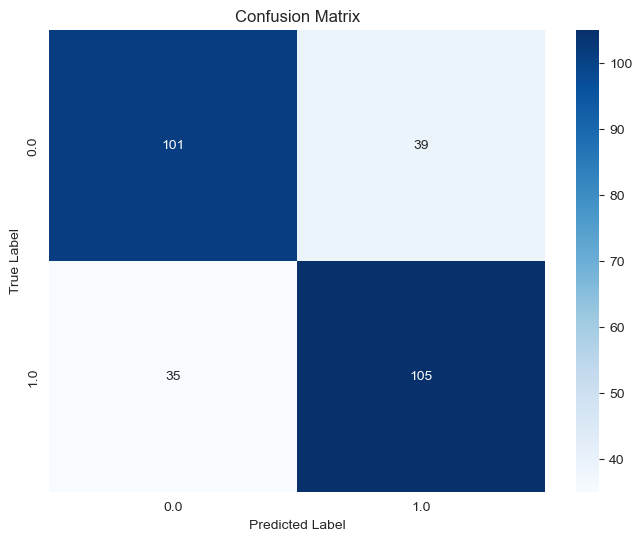

In [379]:
############################################### Machine Learning ###############################################
#2. Build a Simple Model  
# • Choose a modeling goal: e.g., user segmentation, outcome prediction, or recommendation. 
# • Select and justify a model (logistic regression, decision trees, simple neural net, etc.). 
# • Train and validate (simple train/test split is fine). 

# 1. I want to classify a provider as being either a contractor of nurses or employer of nurses 
#    • This is to recommend to a traveling nurse, a place to apply to live
#    • Binary nature and small dataset size suggests a binary model - Logistic regression 
# 2. I split using train_test from sklearn
# 3. I use a standard scalar with LDA to improve performance
# 4. I calculate precision, recall, f1, confusion matrix w/ chart, and overall accuracy
############################################### Machine Learning ###############################################
################################################################################################################ 1
# Logistic Regression w/ lda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix, roc_auc_score,accuracy_score
from sklearn.metrics import accuracy_score

base_dir = os.getcwd() + "\\parquet\\"
pin = pl.read_parquet(base_dir + "data_ml.parquet")

# Separate features and target variable
other=True

X = pin.drop('ML_Label')
y = pin['ML_Label']

################################################################################################################ 2
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

################################################################################################################ 3
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply LDA for dimensionality reduction
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

# Train logistic regression model
logistic_model = LogisticRegression(random_state=32)
logistic_model.fit(X_train_lda, y_train)

# Make predictions
y_pred_lda = logistic_model.predict(X_test_lda)

################################################################################################################ 4
# Evaluate the model with lda
precision = precision_score(y_test, y_pred_lda)
print(f'Precision: {precision}')

recall = recall_score(y_test, y_pred_lda)
print(f'Recall: {recall}')

f1 = f1_score(y_test, y_pred_lda)
print(f'F1 Score: {f1}')

classes = np.unique(np.concatenate((y_test, y_pred_lda)))
conf_matrix = confusion_matrix(y_test, y_pred_lda, labels=classes)
print(f'Confusion Matrix:\n{conf_matrix}')

roc_auc = roc_auc_score(y_test, y_pred_lda)
print(f'ROC AUC: {roc_auc}')

# Evaluate the model
accuracy_lda = accuracy_score(y_test, y_pred_lda)
print(f"Accuracy with lda: {accuracy_lda}")

show = False
if show:
    plt.figure(figsize=(30,20)) 
    sns.heatmap(pin.corr(), annot=True)
    plt.figure(figsize=(30,20))
    sns.pairplot(pin.to_pandas(), hue='ML_Label', vars=potent)
    plt.figure(figsize=(30,20))
    sns.countplot(pin.to_pandas()['ML_Label'], label = "ML_Label")
    
show = True
if show:
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    


# Perform a MultiLayer Perceptron Neural Network
Report Precision, Recall, F1, Accuracy and Confusion Matrix

Precision: 0.7152317880794702
Recall: 0.8
F1 Score: 0.7552447552447552
Confusion Matrix:
[[102  43]
 [ 27 108]]
ROC AUC: 0.7517241379310347


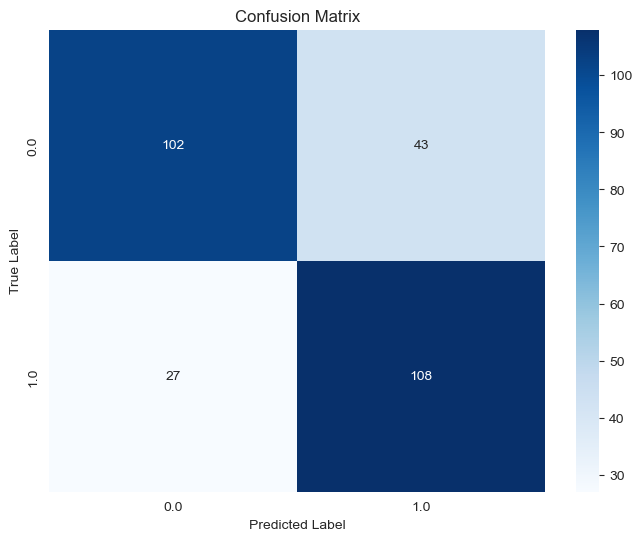

Accuracy with lda: 0.75


In [381]:
############################################### Machine Learning ###############################################
# Logistic Regression with LDA is perfectly fine to use
# I wanted to test this out
############################################### Machine Learning ###############################################
import polars as pl
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, normalize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix, roc_auc_score,accuracy_score
import matplotlib.pyplot as plt

# Get Data
base_dir = os.getcwd() + "\\parquet\\"
pin = pl.read_parquet(base_dir + "data_ml.parquet")


# create df X, without the label
X = pin.drop("ML_Label")

# create df y, of label
y = pin["ML_Label"]

# 1008 training, 252 testing, 140 val
# split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, shuffle=True)

# normalize the data using a scaler (balance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

show=False

# Apply LDA for dimensionality reduction
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

# solver      adam lbfgs sgd
# learning    {'adaptive', 'constant', 'invscaling'}.
# 
mlp = MLPClassifier(
    hidden_layer_sizes=(1 ),
    learning_rate='constant', 
    momentum=0.0009,
    tol=.00001,
    max_iter=5000, 
    random_state=7,
    solver='sgd',
    activation='logistic',
    alpha=0.0001,
    batch_size='auto',
    learning_rate_init=0.055,
    power_t=0.5,
    shuffle=True, 
    warm_start=False,
    nesterovs_momentum=True, 
    early_stopping=False,
    validation_fraction=0.1, 
    beta_1=0.9,
    beta_2=0.999, 
    epsilon=1e-08, 
    n_iter_no_change=30, 
    max_fun=15000,
    verbose=False,
)

mlp.fit(X_train_lda, y_train)
y_pred_lda = mlp.predict(X_test_lda)

mlp.fit(X_train_scaled, y_train)
y_pred_scaled = mlp.predict(X_test_scaled)

# Evaluate the model with lda
precision = precision_score(y_test, y_pred_lda)
print(f'Precision: {precision}')

recall = recall_score(y_test, y_pred_lda)
print(f'Recall: {recall}')

f1 = f1_score(y_test, y_pred_lda)
print(f'F1 Score: {f1}')

classes = np.unique(np.concatenate((y_test, y_pred_lda)))
conf_matrix = confusion_matrix(y_test, y_pred_lda, labels=classes)
print(f'Confusion Matrix:\n{conf_matrix}')

roc_auc = roc_auc_score(y_test, y_pred_lda)
print(f'ROC AUC: {roc_auc}')
show=True
if show:
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


accuracy_lda = accuracy_score(y_test, y_pred_lda)
print(f"Accuracy with lda: {accuracy_lda}")
        
